# LSTM

In [1]:
import glob
from pathlib import Path
import tqdm as tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchtext.data import get_tokenizer
from tqdm.notebook import tqdm
from google_drive_downloader import GoogleDriveDownloader as gdd

torch.manual_seed(0)


In [3]:
# Download data

gdd.download_file_from_google_drive('13DLnvpRhDO-D5JHCuPq85k_v-yMiMNCQ', '~/lingsmap_public-bare.zip', unzip=True)
assert Path('~/lingsmap_public-bare').exists()


  0%|          | 0/2893 [00:00<?, ?it/s]

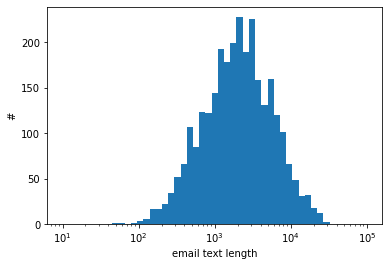

2893 emails
percentage spam: 0.17
ascii codes between 10 and 126


In [4]:
# Load data

filepaths = glob.glob('~/lingsmap_public-bare/*/*.txt')
emails = []
emails_ascii = []
targets = []

for i, filepath in enumerate(tqdm(filepaths)):
    with open(filepath) as file:
        email = file.read()
    emails.append(email)
    # convert character to ascii code
    emails_ascii.append([ord(c) for c in email])
    targets.append('spmsg' in filepath)

plt.hist([len(e) for e in emails], np.logspace(1, 5))
plt.xlabel('email text length')
plt.ylabel('#')
plt.xscale('log')
plt.show()

print(f'{len(emails)} emails')
print(f'percentage spam: {np.mean(targets):.2f}')
emails_ascii_flat = np.concatenate(emails_ascii)
print(
    f'ascii codes between {emails_ascii_flat.min()} and {emails_ascii_flat.max()}')


# So even if we just guess 'not spam' all the time, we can get 83 % correct. Lets consider this as the **baseline**.

In [5]:
# Preprocess emails
import string
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
# nltk.download() needed if data isnt stored

tokenizer = get_tokenizer("basic_english")
stop_words = stopwords.words('english')
for i in range(256):
    stop_words.append(chr(i))


def clean_text(text):
    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join(
        [char.lower() for char in text_nonum if char not in string.punctuation])
    # substitute multiple whitespace with single whitespace, also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    return text_no_doublespace


def pre_process_words(email):
    global tokenizer
    text = clean_text(email)
    tokens = tokenizer(text)
    tokens = [word for word in tokens if not word in stop_words]
    return np.array(tokens)


def gen_vocab(emails):
    # take the mails and cat them
    email_cat = emails[0]
    for i in range(1, len(emails)):
        email_cat += " " + emails[i]
    # clean text from punctuations etc
    words = pre_process_words(email_cat)
    # get unique vocals
    return np.unique(words)

# Dataset



In [7]:
class SpamEmailsDataset(torch.utils.data.Dataset):

    def __init__(self, emails, targets, samples = 100):
        vocab = np.append(gen_vocab(emails.copy()), ' ')
        self.vocab_dict = {ele: i for i, ele in enumerate(vocab)}
        self.targets = torch.tensor(targets).to(torch.float32)
        self.data = []
        self.samples = samples
        for i in range(len(emails)):
            self.data.append(pre_process_words(emails[i]))

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, idx):
        # Index
        index = np.random.randint(0, self.data[idx].shape[0], (1))[0]
        # Ternary
        if index+self.samples>self.data[idx].shape[0]:
            email = self.data[idx][index:]
        else:
            email = self.data[idx][index:index+self.samples]
        # Empty tensor
        tensor = torch.zeros((self.samples), dtype=torch.int64)
        for i in range(len(email)):
            tensor[i] = self.vocab_dict[email[i]]
        return tensor, torch.LongTensor([len(email)-1]), self.targets[idx]

In [8]:
# spam email dataset, a whole lot of pre-processing occurs in here, so it might be slow
spam_email_dataset = SpamEmailsDataset(emails, targets)

# split training data up
(train_set, valid_set, test_set) = torch.utils.data.random_split(spam_email_dataset, [2400, 200, 2893-2400-200])

# dataloaders
batch_size = 64
loader_train = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True, num_workers=12)
loader_valid = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle=True, num_workers=12)
loader_test = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle=True, num_workers=12)

In [9]:
class SpamMailLSTM(nn.Module):
    
    def __init__(self, hidden_dim, n_layers, output_size=1, vocab_size=57150, embedding_dim=100, drop_lstm=0.10):
        super().__init__()

        # Output size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # Embedding
        self.emb = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_lstm, batch_first=True)
        self.lin = nn.Linear(hidden_dim, output_size)

    def forward(self, x, end_index):
        end_index = end_index.reshape(-1)
        x = self.emb(x)
        y = self.lstm(x)[0][torch.arange(len(x)), end_index]
        return torch.sigmoid(self.lin(y)).view(-1)


In [10]:
# Hyperparameters:
SETTINGS = {
            "batch_size": batch_size,
            "embedding_dim": 100,
            "n_layers": 2,
            "hidden_dim": 512,
            "epoch": 20,
            "lr": 5e-4,
            "clip": 1
            }

device = torch.device("cuda")

  0%|          | 0/20 [00:00<?, ?it/s]

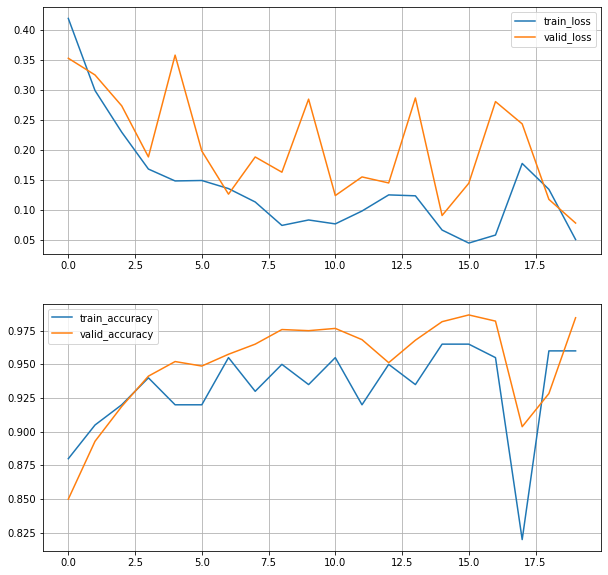

In [14]:
net = SpamMailLSTM(
                             hidden_dim=SETTINGS["hidden_dim"],
                             n_layers=SETTINGS["n_layers"],
                             output_size=1,
                             vocab_size=57150,
                             embedding_dim=SETTINGS["embedding_dim"]
                             ).to(device)

opt = torch.optim.Adam(net.parameters(), SETTINGS["lr"])

train_loss, valid_loss = [], []
train_accuracy, valid_accuracy = [], []

for epoch in tqdm(range(SETTINGS["epoch"])):

    # Set to training mode
    net.train()

    # Parameters
    losses, accuracy = [], []

    for x, end_index, y in loader_train:

        # Get data pairs (input, target)
        x, y = x.to(device), y.to(device)
        
        # Returns the logits
        logits = net(x, end_index)

        # Compute the loss
        loss = F.binary_cross_entropy(logits, y)
        opt.zero_grad()
        loss.backward()

        # Step
        nn.utils.clip_grad_norm_(net.parameters(), SETTINGS["clip"])
        opt.step()

        accuracy.append((torch.sum((logits > 0.5).to(torch.float32) == y)).detach().cpu().item())
        losses.append(loss.item())

    # Update loss
    train_loss.append(np.mean(losses))
    train_accuracy.append(np.sum(accuracy)/2400)

    # Set to eval mode
    net.eval()
    
    with torch.no_grad():

        # Parameters
        losses, accuracy = [], []
        for x, end_index, y in loader_valid:

            # Get data pairs (input, target)
            x, y = x.to(device), y.to(device)

            # Returns the logits
            logits = net(x, end_index)

            # Compute the loss
            loss = F.binary_cross_entropy(logits, y)
            accuracy.append((torch.sum((logits > 0.5).to(torch.float32) == y)).detach().cpu().item())
            losses.append(loss.item())

    # Update loss
    valid_loss.append(np.mean(losses))
    valid_accuracy.append(np.sum(accuracy)/200)

plt.figure(1, figsize=(10, 10))

plt.subplot(2,1,1)
plt.plot(train_loss, label="train_loss")
plt.plot(valid_loss, label="valid_loss")
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(valid_accuracy, label="train_accuracy")
plt.plot(train_accuracy, label="valid_accuracy")
plt.legend()
plt.grid()
plt.show()


In [22]:
net.eval()

with torch.no_grad():

    # Parameters
    losses, accuracy = [], []

    for x, end_index, y in loader_test:

        # Get data pairs (input, target)
        x, y = x.to(device), y.to(device)

        # Returns the logits
        logits = net(x, end_index)
        
        loss = F.binary_cross_entropy_with_logits(logits, y)

        # Accuracy
        accuracy.append((torch.sum((logits > 0.5).to(torch.float32) == y)).detach().cpu().item())

print("I have not incorporated sample versus not-sampled based.")
print(np.sum(accuracy)/(2893-2400-200))

I have not incorporated sample versus not-sampled based.
0.9726962457337884
